# BYOL Model for Alzheimer Classification

# Contents of file


1) BYOL Model pretraining on Unlabelled data

2) Fine-Tuning the trained model to Downstream classification of Alzheimer Disease

3) Visualizing the important regions of image important in making decison using Grad-CAM (Gradient-weighted Class Activation Mapping)

4) Utilizing the Learned representation from Alzheimer images to fine-tune and classify Tumor Images.


In [61]:
import os
import torch
import torch.nn as nn
from torchvision import models, datasets
import torch.nn.functional as F
import numpy as np
from PIL import Image
import random
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import copy
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image



In [62]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [63]:
class FlatImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname)
                            for fname in os.listdir(root_dir)
                            if fname.lower().endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            return self.transform(img)
        else:
            return img


In [64]:
labelled_path = "/projects/academic/courses/cse676s25/pgulhane/alzheimer_dataset_labelled"
unlabelled_path = "/projects/academic/courses/cse676s25/pgulhane/alzheimer_dataset_unlabelled"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



unlabelled_dataset = FlatImageDataset(root_dir=unlabelled_path, transform=transform)

dataloader = DataLoader(unlabelled_dataset, batch_size=128, shuffle=True, num_workers=4)


In [65]:
class Encoder_Layer(nn.Module):
    def __init__(self):
        super(Encoder_Layer, self).__init__()
        resnet_arch = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet_arch.children())[:-1])
        self.feature_dimension = 2048

    def forward(self, x):
        x = self.backbone(x)
        return x.view(x.size(0), -1)

class ProjectionLayer(nn.Module):
    def __init__(self, in_dimension=2048, out_dimension=256):
        super(ProjectionLayer, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dimension, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, out_dimension)
        )

    def forward(self, x):
        return self.mlp(x)

class PredictionLayer(nn.Module):
    def __init__(self, in_dimension=256):
        super(PredictionLayer, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dimension, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, in_dimension)
        )

    def forward(self, x):
        return self.mlp(x)

class BYOL(nn.Module):
    def __init__(self):
        super(BYOL, self).__init__()
        self.encoder = Encoder_Layer()
        self.projection_layer = ProjectionLayer(in_dimension=self.encoder.feature_dimension)
        self.predictor = PredictionLayer()

        self.target_encoder = copy.deepcopy(self.encoder)
        self.target_projection_layer = copy.deepcopy(self.projection_layer)
        for param in self.target_encoder.parameters():
            param.requires_grad = False
        for param in self.target_projection_layer.parameters():
            param.requires_grad = False

    def forward(self, x1, x2):
        z1_online = self.projection_layer(self.encoder(x1))
        z2_online = self.projection_layer(self.encoder(x2))
        p1 = self.predictor(z1_online)
        p2 = self.predictor(z2_online)

        with torch.no_grad():
            z1_target = self.target_projection_layer(self.target_encoder(x1))
            z2_target = self.target_projection_layer(self.target_encoder(x2))

        return p1, p2, z1_target, z2_target

def loss_function_BYOL(p1, p2, z1_target, z2_target):
    loss = (F.mse_loss(p1, z2_target) + F.mse_loss(p2, z1_target)) / 2
    return loss

def target_network_mov_avg(online_path, target_path, tau=0.99):
    for param_online, param_target in zip(online_path.parameters(), target_path.parameters()):
        param_target.data = tau * param_target.data + (1 - tau) * param_online.data



In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
byol_pretrain = BYOL().to(device)
optimizer = torch.optim.Adam(byol_pretrain.parameters(), lr=0.0001)

num_epochs = 10
for epoch in range(num_epochs):
    for images in dataloader:
        aug1, aug2 = images.to(device), images.to(device)
        optimizer.zero_grad()

        pred1, pred2, z1_target, z2_target = byol_pretrain(aug1, aug2)
        loss = loss_function_BYOL(pred1, pred2, z1_target, z2_target)
        loss.backward()
        optimizer.step()

        target_network_mov_avg(byol_pretrain.encoder, byol_pretrain.target_encoder)
        target_network_mov_avg(byol_pretrain.projection_layer, byol_pretrain.target_projection_layer)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.0241
Epoch 2/10, Loss: 0.0041
Epoch 3/10, Loss: 0.0037
Epoch 4/10, Loss: 0.0265
Epoch 5/10, Loss: 0.0079
Epoch 6/10, Loss: 0.0172
Epoch 7/10, Loss: 0.0081
Epoch 8/10, Loss: 0.0133
Epoch 9/10, Loss: 0.0096
Epoch 10/10, Loss: 0.0113


In [67]:
torch.save(byol_pretrain.state_dict(), "BYOL_optimized.pth")

# Fine-Tuning For Alzheimer Classification

In [68]:
data_transforms_labeled = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path_labeled = "/projects/academic/courses/cse676s25/pgulhane/alzheimer_dataset_labelled"
labeled_dataset = ImageFolder(root=dataset_path_labeled, transform=data_transforms_labeled)
num_classes = len(labeled_dataset.classes)

train_size = int(0.7 * len(labeled_dataset))
val_size = int(0.15 * len(labeled_dataset))
test_size = len(labeled_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(labeled_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [69]:
class AlzheimerClassifier(nn.Module):
    def __init__(self, pretrained_encoder, num_classes):
        super(AlzheimerClassifier, self).__init__()
        self.encoder = pretrained_encoder
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

byol_model = BYOL().to(device)
byol_model.load_state_dict(torch.load("BYOL_optimized.pth"))
pretrained_encoder = byol_model.encoder

byol_finetune = AlzheimerClassifier(pretrained_encoder, num_classes).to(device)

for param in byol_finetune.encoder.parameters():
    param.requires_grad = False

fine_tune_Loss_func = nn.CrossEntropyLoss()
optimizer_train = optim.Adam(byol_finetune.classifier.parameters(), lr=0.0003)


In [70]:
def evaluate_model(evaluate_model,data_loader):
    evaluate_model.eval()
    total_loss, correct_pred, total_len = 0, 0, 0
    preds_all, labels_all = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = evaluate_model(images)
            loss = fine_tune_Loss_func(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_pred += predicted.eq(labels).sum().item()
            total_len += labels.size(0)
            preds_all.extend(predicted.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    accuracy = 100 * correct_pred / total_len
    print(f" Loss: {total_loss/len(data_loader):.4f} Accuracy: {accuracy:.2f}%")
    return labels_all, preds_all


In [71]:
def train(model_ft,train_loader,val_loader,optimizer,criterion,num_epochs):    
    losses_collect = []
    accuracies_collect = []
    val_losses, val_accs =[],[]
    for epoch in range(num_epochs):        
        model_ft.train()
        total_loss, correct_pred, total_len = 0, 0, 0

        for images, labels in train_loader:            
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_ft(images)
            loss = fine_tune_Loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_pred += predicted.eq(labels).sum().item()
            total_len += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct_pred / total_len
        losses_collect.append(avg_loss)
        accuracies_collect.append(accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs},Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
        
        model_ft.eval()
        total_loss, correct_pred, total_len = 0, 0, 0
        preds_all, labels_all = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_ft(images)
                loss = fine_tune_Loss_func(outputs, labels)
                total_loss += loss.item()
                _, predicted = outputs.max(1)
                correct_pred += predicted.eq(labels).sum().item()
                total_len += labels.size(0)
        accuracy = 100 * correct_pred / total_len
        print(f"Validation Loss: {total_loss/len(val_loader):.4f} Validation AccuracyAccuracy: {accuracy:.2f}%")
        val_losses.append(total_loss/len(val_loader))
        val_accs.append(accuracy)
    return losses_collect,accuracies_collect, val_losses, val_accs



In [72]:
def plot_loss_accuracy_train(losses_alz,finetune_losses_alz,accuracies_alz, finetune_accuracies_alz,val_losses_alz,val_accuracies_alz,val_finetune_losses_alz,val_finetune_accuracies_alz,num_epochs,num_finetune_epochs,disease):
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), losses_alz, label='Train :Pretrain Loss for '+disease, color="blue",marker='o')
    plt.plot(range(num_epochs, num_epochs+num_finetune_epochs), finetune_losses_alz, label='Train Finetune Loss for '+disease,color="blue", marker='o')
    plt.plot(range(1, num_epochs+1), val_losses_alz, label='Val :Pretrain Loss for '+disease, color="orange",marker='o')
    plt.plot(range(num_epochs, num_epochs+num_finetune_epochs), val_finetune_losses_alz, label='Val : Finetune Loss for '+disease,color="orange", marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve for '+disease)
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), accuracies_alz, label='Train :Pretrain Accuracy  for '+disease,color="blue", marker='o')
    plt.plot(range(num_epochs, num_epochs+num_finetune_epochs), finetune_accuracies_alz, label='Train : Finetune Accuracy for '+disease,color="blue", marker='o')
    plt.plot(range(1, num_epochs+1), val_accuracies_alz, label='Val :Pretrain Accuracy for '+disease,color="orange", marker='o')
    plt.plot(range(num_epochs, num_epochs+num_finetune_epochs), val_finetune_accuracies_alz, label='Val :Finetune Accuracy for '+disease,color="orange", marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Curve for '+disease)
    plt.legend()
    plt.grid(True)
    plt.show()

Pre Training for Alzheimer disease
Epoch 1/10,Train Loss: 1.2565, Train Accuracy: 39.68%
Validation Loss: 1.1822 Validation AccuracyAccuracy: 44.07%
Epoch 2/10,Train Loss: 1.1638, Train Accuracy: 45.95%
Validation Loss: 1.1445 Validation AccuracyAccuracy: 47.78%
Epoch 3/10,Train Loss: 1.1494, Train Accuracy: 45.56%
Validation Loss: 1.1251 Validation AccuracyAccuracy: 47.78%
Epoch 4/10,Train Loss: 1.1352, Train Accuracy: 46.35%
Validation Loss: 1.1285 Validation AccuracyAccuracy: 50.00%
Epoch 5/10,Train Loss: 1.1061, Train Accuracy: 49.44%
Validation Loss: 1.1279 Validation AccuracyAccuracy: 48.52%
Epoch 6/10,Train Loss: 1.1088, Train Accuracy: 48.57%
Validation Loss: 1.1054 Validation AccuracyAccuracy: 48.52%
Epoch 7/10,Train Loss: 1.0851, Train Accuracy: 49.44%
Validation Loss: 1.1208 Validation AccuracyAccuracy: 47.41%
Epoch 8/10,Train Loss: 1.1041, Train Accuracy: 49.05%
Validation Loss: 1.1029 Validation AccuracyAccuracy: 52.59%
Epoch 9/10,Train Loss: 1.0799, Train Accuracy: 49.68%

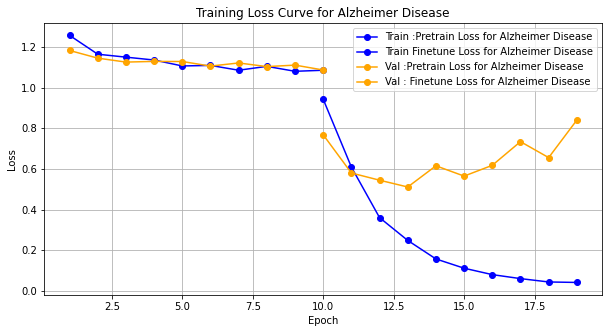

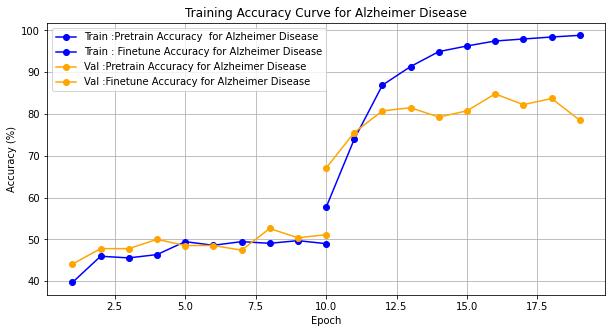

In [73]:
print("Pre Training for Alzheimer disease")
losses_alz,accuracies_alz,val_losses_alz,val_accuracies_alz = train(byol_finetune,train_loader,val_loader,optimizer_train,fine_tune_Loss_func,10)


for param in byol_finetune.encoder.parameters():
    param.requires_grad = True

print("Fine Training for Alzheimer disease")
optimizer_train_finetune = optim.Adam(byol_finetune.parameters(), lr=0.0001)
finetune_losses_alz,finetune_accuracies_alz,val_finetune_losses_alz,val_finetune_accuracies_alz = train(byol_finetune,train_loader,val_loader,optimizer_train_finetune,fine_tune_Loss_func,10)


plot_loss_accuracy_train(losses_alz,finetune_losses_alz,accuracies_alz, finetune_accuracies_alz,val_losses_alz,val_accuracies_alz,val_finetune_losses_alz,val_finetune_accuracies_alz,10,10,'Alzheimer Disease')

Testing Model on test Data set
 Loss: 0.6095 Accuracy: 86.30%


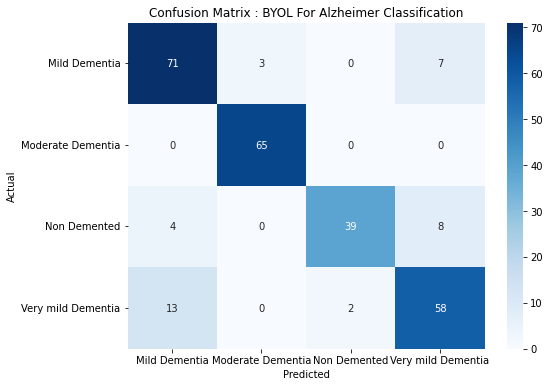

Classification Report for BYOL: For Alzheimer Classification
                    precision    recall  f1-score   support

     Mild Dementia       0.81      0.88      0.84        81
 Moderate Dementia       0.96      1.00      0.98        65
      Non Demented       0.95      0.76      0.85        51
Very mild Dementia       0.79      0.79      0.79        73

          accuracy                           0.86       270
         macro avg       0.88      0.86      0.87       270
      weighted avg       0.87      0.86      0.86       270



In [84]:
print("Testing Model on test Data set")
test_labels, test_preds = evaluate_model(byol_finetune,test_loader)

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labeled_dataset.classes, yticklabels=labeled_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix : BYOL For Alzheimer Classification")
plt.show()

print("Classification Report for BYOL: For Alzheimer Classification")
print(classification_report(test_labels, test_preds, target_names=labeled_dataset.classes))

In [75]:
torch.save(byol_finetune.state_dict(), "BYOL_Alz_finetuned.pth")

# Visualizing the important regions of image important in making decison using Grad-CAM (Gradient-weighted Class Activation Mapping)

In [76]:
def generate_grad_cam_image(prediction_model,test_loader):
    prediction_model.eval()
    target_network= prediction_model.encoder.backbone[-2]
    cam_func = GradCAM(model=prediction_model, target_layers=[target_network])

    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    img_num = 0
    input_img = images[img_num].unsqueeze(0)

    pred = prediction_model(input_img)
    pred_class = pred.argmax(dim=1).item()

    targets = [ClassifierOutputTarget(pred_class)]
    grayscale_img = cam_func(input_tensor=input_img, targets=targets)[0, :]

    mean = np.array([0.5, 0.5, 0.5])
    standard_dev = np.array([0.5, 0.5, 0.5])
    image = input_img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    image = (image * standard_dev) + mean
    image = np.clip(image, 0, 1)

    cam_image = show_cam_on_image(image, grayscale_img, use_rgb=True)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Input  Image\nTrue Label: {labeled_dataset.classes[labels[img_num]]}")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.title(f"Grad-CAM\nPredicted: {labeled_dataset.classes[pred_class]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


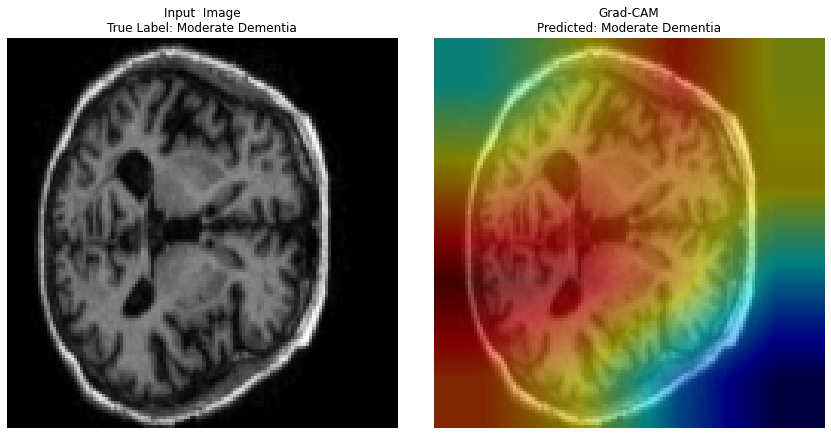

In [77]:
generate_grad_cam_image(byol_finetune,test_loader)

# We get an idea of part of Image that is Influencing the decision for Classification.

# Domain-specific self-supervised pretraining- Classifying Tumors

In [78]:
data_transforms_labeled_tumor = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path_labeled_tumor = "/projects/academic/courses/cse676s25/pgulhane/Testing"
labeled_dataset_tumor = ImageFolder(root=dataset_path_labeled_tumor, transform=data_transforms_labeled_tumor)
num_classes = len(labeled_dataset_tumor.classes)

class TumorClassifier(nn.Module):
    def __init__(self, pretrained_encoder, num_classes):
        super(TumorClassifier, self).__init__()
        self.encoder = pretrained_encoder
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

byol_model = BYOL().to(device)
byol_model.load_state_dict(torch.load("BYOL_optimized.pth"))
pretrained_encoder = byol_model.encoder

tumor_classifier = TumorClassifier(pretrained_encoder, num_classes).to(device)

/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pre Training for Tumor Classification
Epoch 1/10,Train Loss: 1.2743, Train Accuracy: 38.10%
Validation Loss: 1.1951 Validation AccuracyAccuracy: 44.44%
Epoch 2/10,Train Loss: 1.1674, Train Accuracy: 44.92%
Validation Loss: 1.2344 Validation AccuracyAccuracy: 39.63%
Epoch 3/10,Train Loss: 1.1468, Train Accuracy: 45.40%
Validation Loss: 1.1433 Validation AccuracyAccuracy: 46.30%
Epoch 4/10,Train Loss: 1.1353, Train Accuracy: 45.24%
Validation Loss: 1.1383 Validation AccuracyAccuracy: 47.04%
Epoch 5/10,Train Loss: 1.1107, Train Accuracy: 48.10%
Validation Loss: 1.1290 Validation AccuracyAccuracy: 46.67%
Epoch 6/10,Train Loss: 1.1098, Train Accuracy: 48.41%
Validation Loss: 1.1343 Validation AccuracyAccuracy: 42.22%
Epoch 7/10,Train Loss: 1.1148, Train Accuracy: 49.21%
Validation Loss: 1.1354 Validation AccuracyAccuracy: 44.44%
Epoch 8/10,Train Loss: 1.0876, Train Accuracy: 50.16%
Validation Loss: 1.1180 Validation AccuracyAccuracy: 46.30%
Epoch 9/10,Train Loss: 1.0736, Train Accuracy: 48.

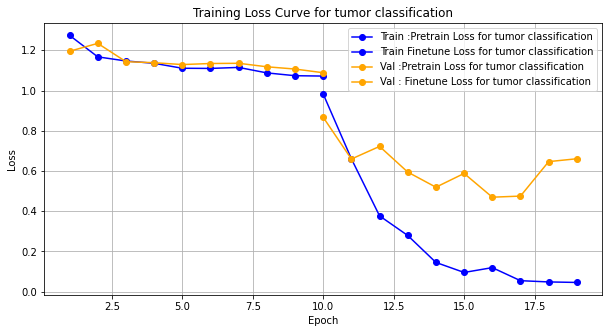

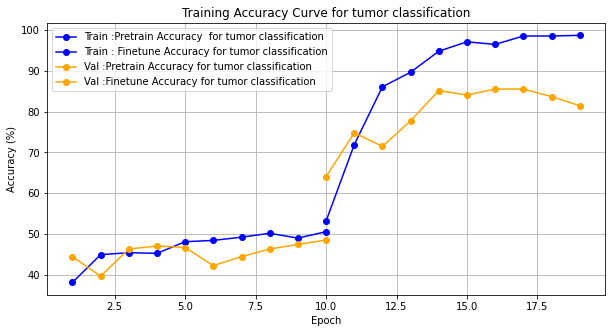

In [79]:
for param in tumor_classifier.encoder.parameters():
    param.requires_grad = False

loss_func_tumor = nn.CrossEntropyLoss()
optimizer_train_tumor = optim.Adam(tumor_classifier.classifier.parameters(), lr=0.0003)


print("Pre Training for Tumor Classification")
losses_tum,accuracies_tum,val_losses_tum,val_accuracies_tum = train(tumor_classifier,train_loader,val_loader,optimizer_train_tumor,loss_func_tumor,10)


for param in tumor_classifier.encoder.parameters():
    param.requires_grad = True

print("Fine Training for Tumor Classification")
optimizer_train_finetune_tumor = optim.Adam(tumor_classifier.parameters(), lr=0.0001)
finetune_losses_tum,finetune_accuracies_tum,val_finetune_losses_tum,val_finetune_accuracies_tum = train(tumor_classifier,train_loader,val_loader,optimizer_train_finetune_tumor,loss_func_tumor,10)


plot_loss_accuracy_train(losses_tum,finetune_losses_tum,accuracies_tum, finetune_accuracies_tum,val_losses_tum,val_accuracies_tum,val_finetune_losses_tum,val_finetune_accuracies_tum,10,10,'tumor classification')

Testing Model on test Data set
 Loss: 0.5660 Accuracy: 86.67%


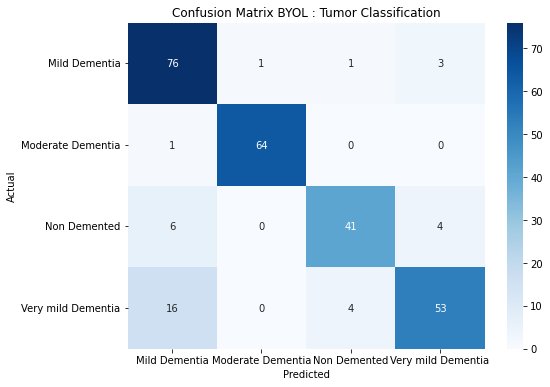

Classification Report: BYOL : Tumor Classification
                    precision    recall  f1-score   support

     Mild Dementia       0.77      0.94      0.84        81
 Moderate Dementia       0.98      0.98      0.98        65
      Non Demented       0.89      0.80      0.85        51
Very mild Dementia       0.88      0.73      0.80        73

          accuracy                           0.87       270
         macro avg       0.88      0.86      0.87       270
      weighted avg       0.87      0.87      0.87       270



In [85]:
print("Testing Model on test Data set")
test_labels, test_preds = evaluate_model(tumor_classifier,test_loader)

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labeled_dataset.classes, yticklabels=labeled_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix BYOL : Tumor Classification")
plt.show()

print("Classification Report: BYOL : Tumor Classification")
print(classification_report(test_labels, test_preds, target_names=labeled_dataset.classes))


# We can see that utilizing the BYOL pretrained model which is trained on Alzheimer dataset, we can finetune it to classify Tumor Images as well.

# We are getting an accuracy of around 85% with this approach

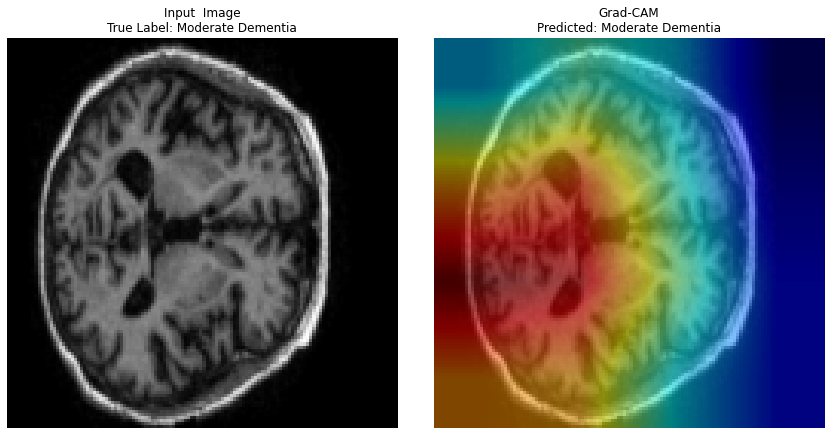

In [82]:
generate_grad_cam_image(tumor_classifier,test_loader)

In [83]:
torch.save(tumor_classifier.state_dict(), "BYOL_tumor_finetuned.pth")

# Conclusion

From the above analysis we can see that by pretraining the model for Alzheimer Image classification using BYOL, we are able classify images with Higher accuracy with limited labelled samples used in training.

Also using the image representation of MRI scan images we are able to use it to classify Brain Tumor as well with good accuracy.Here is the summary for Both the classification task

<table >
    <tr>
        <th > Model <th>
        <th> Test Accuracy <th>
        <th> Test Loss <th>
        <th> Precision <th>
        <th> Recall <th>
        <th> F1 Score <th>
    <tr>
    <tr>
        <td> Base ResNet50 Model <td>
        <td> 74.44% <td>
        <td> 1.1514 <td>
        <td> 0.7835 <td>
        <td> 0.7528 <td>
        <td> 0.7419 <td>
    <tr>
    <tr>
        <td> BYOL preTrianed-Alzheimer Classification<td>
        <td> 86.30% <td>
        <td> 0.6095 <td>
        <td> 0.88 <td>
        <td> 0.86 <td>
        <td> 0.87 <td>
    <tr>
    <tr>
        <td> BYOL preTrianed-Tumor Classification<td>
        <td> 86.67% <td>
        <td> 0.5660 <td>
        <td> 0.88 <td>
        <td> 0.86 <td>
        <td> 0.87 <td>
    <tr>
<table>

Also using Grad-Cam we can visualize the parts of image that influence the classification of image to a particular class, in a doing a detection task by highlighting important part of image that a Doctor should look at to draw some analysis.

Here part of image in RED is High probability region followed by regions with colours like YELLOW/ORANGE represent important regions but less critical while GREEN/BLUE regions mean less important and can be ignored.

References:

1)https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

2)https://openaccess.thecvf.com/content_cvpr_2018/papers/Noroozi_Boosting_Self-Supervised_Learning_CVPR_2018_paper.pdf

3)Bootstrap Your Own Latent A New Approach to Self-Supervised Learning (by DeepMind & Imperial College)

4) Grad-CAM:Visual Explanations from Deep Networks via Gradient-based Localization(by Georgia Institute of Technology & Facebook AI Research)


5)https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html